# Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input, merge, Dropout, Dense, concatenate, dot, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.constraints import non_neg
from tensorflow.keras.utils import model_to_dot
#from keras.utils.visualize_util import model_to_dot

import pydot
import graphviz
from IPython.display import SVG


# Dataset

In [3]:
# on prod use first partial to test then use full datasets
dataset = pd.read_csv('../data/processed_data/active_users_df_10PlusRatings_PG_partial.csv')
anime_df = pd.read_csv('../data/processed_data/anime_df_relevant_PG.csv')
dataset = dataset.sort_values(["user_id", "anime_id"], ascending=(True, True))

## continue on dataset

In [4]:
dataset.anime_id.nunique()

10182

In [5]:
dataset.user_id.nunique()

4022

In [7]:
# Need to map anime ID to [1, anime_num]
anime_id_to_new_id = dict()
id = 1
for index, row in dataset.iterrows():
    if anime_id_to_new_id.get(row['anime_id']) is None:
        anime_id_to_new_id[row['anime_id']] = id
        dataset.at[index, 'anime_id'] = id
        id += 1
    else:
        dataset.at[index, 'anime_id'] = anime_id_to_new_id.get(row['anime_id'])

In [8]:
# Need to map user ID to [1, user_num]
user_id_to_new_id = dict()
id = 1
for index, row in dataset.iterrows():
    if user_id_to_new_id.get(row['user_id']) is None:
        user_id_to_new_id[row['user_id']] = id
        dataset.at[index, 'user_id'] = id
        id += 1
    else:
        dataset.at[index, 'user_id'] = user_id_to_new_id.get(row['user_id'])

In [9]:
dataset.user_id

2748         1
3949         1
0            1
5803         1
8633         1
          ... 
239435    4022
623011    4022
606776    4022
464629    4022
194012    4022
Name: user_id, Length: 807900, dtype: int64

In [10]:
num_users = len(dataset.user_id.unique())
num_animes = len(dataset.anime_id.unique())
train, test = train_test_split(dataset, test_size=0.2)

print('Number of movies', num_animes)
print('Number of users', num_users)

Number of movies 10182
Number of users 4022


# GMF


## Matrix factorisation

In [11]:
# Let's use a higher latent dimension.
latent_dim = 10

anime_input = Input(shape=[1],name='anime-input')
anime_embedding = Embedding(num_animes + 1, latent_dim, name='anime-embedding')(anime_input)
anime_vec = Flatten(name='anime-flatten')(anime_embedding)

user_input = Input(shape=[1],name='user-input')
user_embedding = Embedding(num_users + 1, latent_dim, name='user-embedding')(user_input)
user_vec = Flatten(name='user-flatten')(user_embedding)

prod = dot([anime_vec, user_vec], axes=1, normalize=False, name='dot-product')

model = Model([user_input, anime_input], prod)
model.compile('adam', 'mean_squared_error'
              #,metrics=['mse']
             )

2021-08-29 20:24:30.230014: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-08-29 20:24:30.230045: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-08-29 20:24:30.230063: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mijka-TP): /proc/driver/nvidia/version does not exist
2021-08-29 20:24:30.230261: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


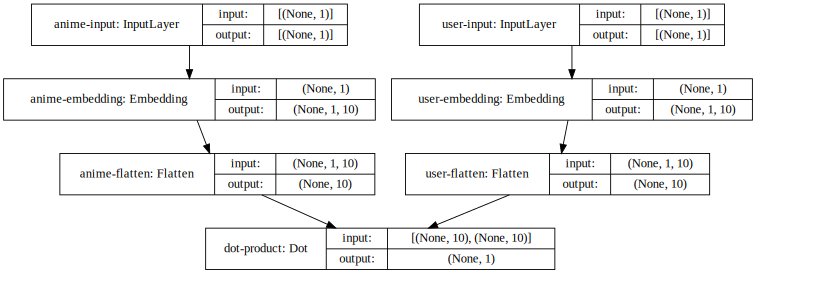

In [12]:
#SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))
SVG(model_to_dot(model, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anime-input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
user-input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
anime-embedding (Embedding)     (None, 1, 10)        101830      anime-input[0][0]                
__________________________________________________________________________________________________
user-embedding (Embedding)      (None, 1, 10)        40230       user-input[0][0]                 
______________________________________________________________________________________________

In [13]:
dataset.rating = dataset.rating.astype(float)

In [14]:
dataset.dtypes

user_id       int64
anime_id      int64
rating      float64
dtype: object

In [15]:
train.user_id.shape

(646320,)

In [16]:
train.anime_id.shape

(646320,)

In [17]:
train.rating.shape

(646320,)

In [35]:
history = model.fit([train.user_id, train.anime_id], train.rating, epochs=10)

Epoch 1/4


2021-08-29 18:25:15.995661: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


20198/20198 [==============================] - 43s 2ms/step - loss: 21.1265
Epoch 2/4
20198/20198 [==============================] - 45s 2ms/step - loss: 2.9112
Epoch 3/4
20198/20198 [==============================] - 42s 2ms/step - loss: 2.1979
Epoch 4/4
20198/20198 [==============================] - 36s 2ms/step - loss: 1.9949


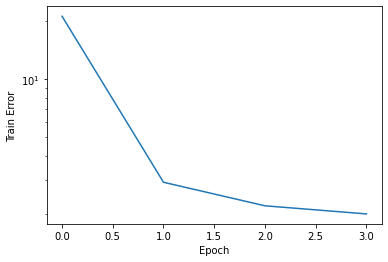

7.480500742666129

In [43]:
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

y_hat = np.round(model.predict([test.user_id, test.anime_id]), decimals=2)
y_true = test.rating
mean_absolute_error(y_true, y_hat)

## non-negative matrix factorization

In [45]:
latent_dim = 5

anime_input = Input(shape=[1],name='anime-input')
anime_embedding = Embedding(num_animes + 1, latent_dim, name='anime-embedding',
                                                        embeddings_constraint=non_neg())(anime_input)
anime_vec = Flatten(name='anime-flatten')(anime_embedding)

user_input = Input(shape=[1],name='user-input')
user_embedding = Embedding(num_users + 1, latent_dim, name='user-embedding',
                                                      embeddings_constraint=non_neg())(user_input)
user_vec = Flatten(name='user-flatten')(user_embedding)

prod = dot([anime_vec, user_vec], axes=1, normalize=False, name='dot-product')

model = Model([user_input, anime_input], prod)
model.compile('adam', 'mean_squared_error')

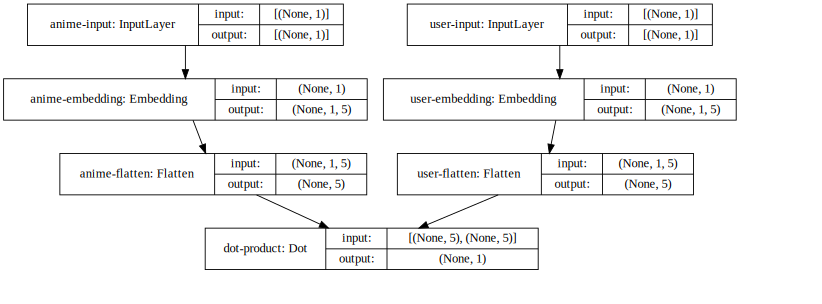

In [46]:
#SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))
SVG(model_to_dot(model, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

In [47]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anime-input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
user-input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
anime-embedding (Embedding)     (None, 1, 5)         50915       anime-input[0][0]                
__________________________________________________________________________________________________
user-embedding (Embedding)      (None, 1, 5)         20115       user-input[0][0]                 
____________________________________________________________________________________________

In [51]:
history = model.fit([train.user_id, train.anime_id], train.rating, epochs=10)
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

y_hat = np.round(model.predict([test.user_id, test.anime_id]), decimals=2)
y_true = test.rating
mean_absolute_error(y_true, y_hat)

Epoch 1/10


TypeError: 'NoneType' object is not callable

# Multi-Layer Perceptron

In [18]:

latent_dim = 10

# Define inputs
anime_input = Input(shape=[1],name='anime-input')
user_input = Input(shape=[1], name='user-input')

# MLP Embeddings
anime_embedding_mlp = Embedding(num_animes + 1, latent_dim, name='anime-embedding-mlp')(anime_input)
anime_vec_mlp = Flatten(name='flatten-anime-mlp')(anime_embedding_mlp)

user_embedding_mlp = Embedding(num_users + 1, latent_dim, name='user-embedding-mlp')(user_input)
user_vec_mlp = Flatten(name='flatten-user-mlp')(user_embedding_mlp)

# MF Embeddings
anime_embedding_mf = Embedding(num_animes + 1, latent_dim, name='anime-embedding-mf')(anime_input)
anime_vec_mf = Flatten(name='flatten-anime-mf')(anime_embedding_mf)

user_embedding_mf = Embedding(num_users + 1, latent_dim, name='user-embedding-mf')(user_input)
user_vec_mf = Flatten(name='flatten-user-mf')(user_embedding_mf)

# MLP layers
concat = concatenate([anime_vec_mlp, user_vec_mlp], axis=1, name='concat')
concat_dropout = Dropout(0.2)(concat)
fc_1 = Dense(100, name='fc-1', activation='relu')(concat_dropout)
fc_1_bn = BatchNormalization(name='batch-norm-1')(fc_1)
fc_1_dropout = Dropout(0.2)(fc_1_bn)
fc_2 = Dense(50, name='fc-2', activation='relu')(fc_1_dropout)
fc_2_bn = BatchNormalization(name='batch-norm-2')(fc_2)
fc_2_dropout = Dropout(0.2)(fc_2_bn)

# Prediction from both layers
pred_mlp = Dense(10, name='pred-mlp', activation='relu')(fc_2_dropout)
pred_mf = dot([anime_vec_mf, user_vec_mf], axes=1, normalize=False, name='pred-mf')
combine_mlp_mf = concatenate([pred_mf, pred_mlp], axis=1, name='combine-mlp-mf')

# Final prediction
result = Dense(1, name='result', activation='relu')(combine_mlp_mf)

model = Model([user_input, anime_input], result)
model.compile(Adam(learning_rate=0.01), loss='mean_absolute_error')

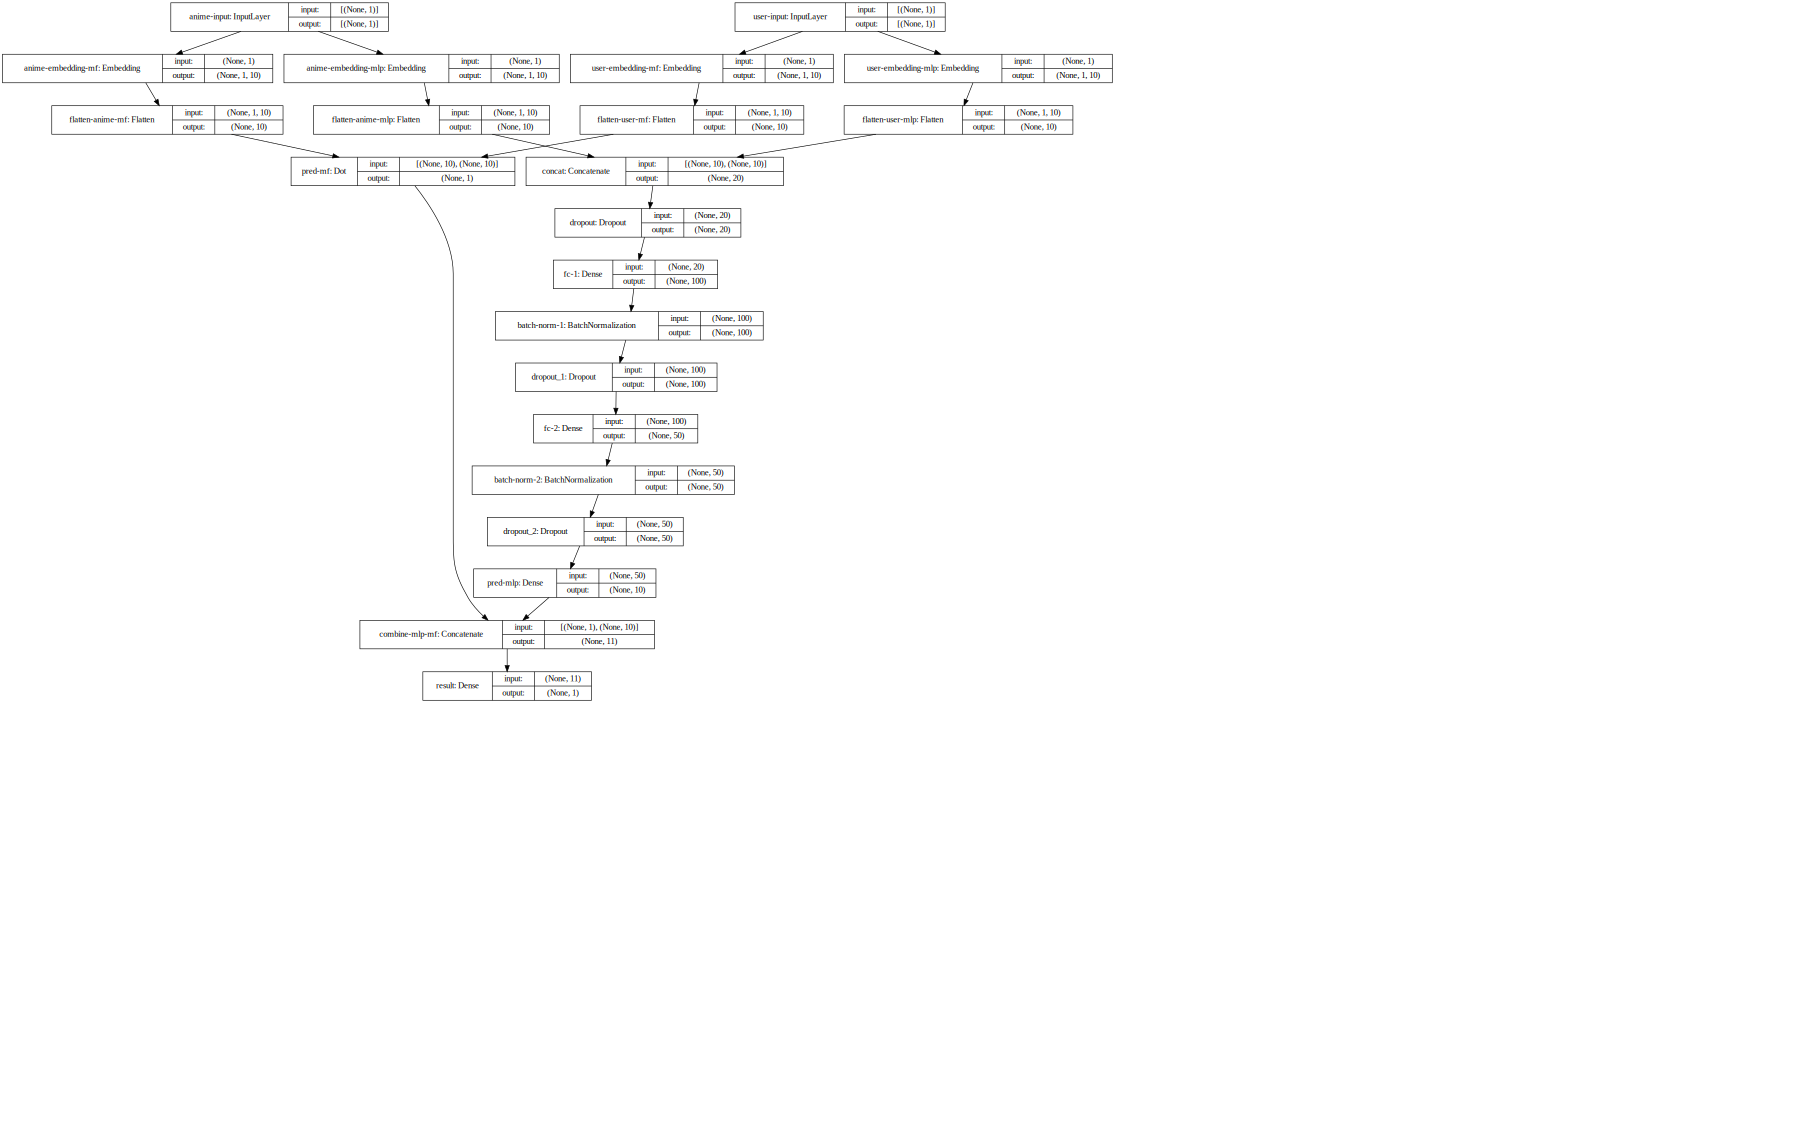

In [19]:
#SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))
SVG(model_to_dot(model, show_shapes= True, show_layer_names=True, dpi=45).create(prog='dot', format='svg'))

In [20]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anime-input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
user-input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
anime-embedding-mlp (Embedding) (None, 1, 10)        101830      anime-input[0][0]                
__________________________________________________________________________________________________
user-embedding-mlp (Embedding)  (None, 1, 10)        40230       user-input[0][0]                 
____________________________________________________________________________________________

In [ ]:
history = model.fit([train.user_id, train.anime_id], train.rating, epochs=10)
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

y_hat = np.round(model.predict([test.user_id, test.anime_id]), decimals=2)
y_true = test.rating
mean_absolute_error(y_true, y_hat)

2021-08-29 20:25:01.890203: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
 3391/20198 [====>.........................] - ETA: 52s - loss: 1.3033